Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.0.2

torch: 2.6.0+cu126



- Runs on CPU (not recommended here) or GPU (if available)

# Model Zoo -- CNN Smile Classifier (VGG16 Architecture, CelebA)

The network in this notebook is an implementation of the VGG-16 [1] architecture on the CelebA face dataset [2] to train a gender classifier.  
本笔记本中的网络是在 CelebA 人脸数据集 [2] 上实现的 VGG-16 架构 [1]，用于训练性别分类器。

References  
参考文献

- [1] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.  
- [1] Simonyan, K., 与 Zisserman, A.（2014）。用于大规模图像识别的非常深的卷积神经网络。arXiv 预印本 arXiv:1409.1556。

- [2] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). Gender and smile classification using deep convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 34-38).  
- [2] Zhang, K., Tan, L., Li, Z., 与 Qiao, Y.（2016）。使用深度卷积神经网络进行性别与微笑分类。发表于 IEEE 计算机视觉与模式识别会议研讨会论文集（第 34–38 页）。

The following table (taken from Simonyan & Zisserman referenced above) summarizes the VGG19 architecture:  
下表（摘自上述 Simonyan 与 Zisserman 的论文）总结了 VGG19 的架构：

![](../images/vgg16/vgg16-arch-table.png)

**Note that the CelebA images are 218 x 178, not 256 x 256. We resize to 128x128**  
**请注意，CelebA 图像的尺寸为 218 x 178，而不是 256 x 256。我们将其调整为 128x128。**

## General settings and hyperparameters

- Here, we specify some general hyperparameter values and general settings  
  在这里，我们指定了一些通用的超参数值和设置  

- Note that for small datasets, it is not necessary and better not to use multiple workers as it can sometimes cause issues with too many open files in PyTorch. So, if you have problems with the data loader later, try setting `NUM_WORKERS = 0` instead.  
  请注意，对于小型数据集，通常不需要使用多个工作进程，最好避免使用多个工作进程，因为这可能会导致 PyTorch 出现打开过多文件的问题。因此，如果以后遇到数据加载器的问题，可以尝试将 `NUM_WORKERS` 设置为 0。

In [2]:
BATCH_SIZE = 128
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
NUM_WORKERS = 4

## Imports

In [3]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.cuda.set_per_process_memory_fraction(0.6, device=0)

## Dataset

Note that the approx. 200,000 CelebA face image dataset is relatively large (approx. 1.3 Gb). If the following automatic download below does not work (e.g., returning a `BadZipFile: File is not a zip file` error), this is usually to rate limit restrictions by the provider hosting the dataset.  
请注意，大约有 200,000 张 CelebA 人脸图像数据集，数据量相对较大（大约 1.3 Gb）。如果下面的自动下载无法正常工作（例如，返回 `BadZipFile: File is not a zip file` 错误），这通常是由于托管数据集的服务提供商设置了下载速率限制。

You can try to download the dataset manually via the download link provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.  
您可以尝试通过作者在 CelebA 官方网站提供的下载链接手动下载数据集：http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html。

Alternatively, you can download the dataset from here: https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?.  
或者，您也可以从这里下载数据集：https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?。

1. Delete the existing `celeba` folder with the partially downloaded files.  
   删除现有的 `celeba` 文件夹以及部分下载的文件。

2. Place the .zip file in the same directory as this notebook, then unzip it.  
   将 .zip 文件放置在与此笔记本相同的目录中，然后解压缩。

3. The new `celeba` folder should contain the following files:  
   新的 `celeba` 文件夹应包含以下文件：

![](./images/celeba-files.png)

4. Unzip the `celeba/img_align.celeba.zip` archive inside the `celeba` folder  
   解压 `celeba` 文件夹中的 `celeba/img_align.celeba.zip` 压缩包

5. Call the `get_dataloaders_celeba` below with `download=False`  
   调用下面的 `get_dataloaders_celeba` 并设置 `download=False`

In [4]:
##########################
### 数据集处理部分
##########################

# 自定义数据预处理变换（包括裁剪、缩放、归一化等）
custom_transforms = transforms.Compose([
    transforms.CenterCrop((160, 160)),     # 从中心裁剪出 160x160 大小的图像
    transforms.Resize([128, 128]),         # 将图像缩放到 128x128
    transforms.ToTensor(),                 # 将图像转换为 Tensor，并将像素值归一化到 [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 对图像进行标准化，均值和标准差均为 0.5
])


# 定义一个函数来加载 CelebA 数据集，并根据需要返回训练集、验证集和测试集的 DataLoader
def get_dataloaders_celeba(batch_size, num_workers=0,
                           train_transforms=None,
                           test_transforms=None,
                           download=True):
    
    # 如果没有传入训练集的变换，则使用默认的 ToTensor()
    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    # 如果没有传入测试集的变换，则使用默认的 ToTensor()
    if test_transforms is None:
        test_transforms = transforms.ToTensor()
        
    # 获取是否微笑的标签，具体根据 CelebA 数据集的 31 号属性来获取
    get_smile = lambda attr: attr[31]

    # 加载训练集数据，指定数据变换、标签选择以及是否下载
    train_dataset = datasets.CelebA(root='.',
                                    split='train',         # 选择训练集
                                    transform=train_transforms,  # 对训练集应用的变换
                                    target_type='attr',    # 使用属性标签
                                    target_transform=get_smile,  # 使用 get_smile 函数提取是否微笑标签
                                    download=download)     # 是否下载数据集

    # 加载验证集数据
    valid_dataset = datasets.CelebA(root='.',
                                    split='valid',         # 选择验证集
                                    target_type='attr',
                                    target_transform=get_smile,
                                    transform=test_transforms)

    # 加载测试集数据
    test_dataset = datasets.CelebA(root='.',
                                   split='test',          # 选择测试集
                                   target_type='attr',
                                   target_transform=get_smile,
                                   transform=test_transforms)

    # 使用 DataLoader 将训练集数据加载到内存，支持批处理
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,      # 每批数据的大小
                              num_workers=num_workers,    # 加载数据时使用的线程数
                              shuffle=True)                # 是否打乱数据顺序

    # 使用 DataLoader 加载验证集数据，不打乱顺序
    valid_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)
    
    # 使用 DataLoader 加载测试集数据，不打乱顺序
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    # 返回训练集、验证集和测试集的 DataLoader
    return train_loader, valid_loader, test_loader


# 调用 get_dataloaders_celeba 函数，获得对应的数据加载器
train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,            # 批处理大小
    train_transforms=custom_transforms,  # 训练集的预处理变换
    test_transforms=custom_transforms,   # 测试集的预处理变换
    download=False,                    # 是否下载数据
    num_workers=4)                     # 数据加载的线程数


Note that the target vectors of the CelebA datasets are vectors containing 40 attributes:  
请注意，CelebA 数据集的目标向量包含 40 个属性：

```
    00 - 5_o_Clock_Shadow - 5点钟阴影  
    01 - Arched_Eyebrows - 弯曲眉毛  
    02 - Attractive - 吸引人  
    03 - Bags_Under_Eyes - 眼袋  
    04 - Bald - 秃顶  
    05 - Bangs - 刘海  
    06 - Big_Lips - 大嘴唇  
    07 - Big_Nose - 大鼻子  
    08 - Black_Hair - 黑发  
    09 - Blond_Hair - 金发  
    10 - Blurry - 模糊  
    11 - Brown_Hair - 棕色头发  
    12 - Bushy_Eyebrows - 浓密眉毛  
    13 - Chubby - 丰满  
    14 - Double_Chin - 双下巴  
    15 - Eyeglasses - 眼镜  
    16 - Goatee - 山羊胡  
    17 - Gray_Hair - 灰发  
    18 - Heavy_Makeup - 厚重妆容  
    19 - High_Cheekbones - 高颧骨  
    20 - Male - 男性  
    21 - Mouth_Slightly_Open - 嘴巴微张  
    22 - Mustache - 胡子  
    23 - Narrow_Eyes - 狭长眼睛  
    24 - No_Beard - 无胡须  
    25 - Oval_Face - 椭圆脸  
    26 - Pale_Skin - 苍白皮肤  
    27 - Pointy_Nose - 尖鼻子  
    28 - Receding_Hairline - 发际线后退  
    29 - Rosy_Cheeks - 红润的脸颊  
    30 - Sideburns - 鬓角  
    31 - Smiling - 微笑  
    32 - Straight_Hair - 直发  
    33 - Wavy_Hair - 波浪发  
    34 - Wearing_Earrings - 戴耳环  
    35 - Wearing_Hat - 戴帽子  
    36 - Wearing_Lipstick - 涂口红  
    37 - Wearing_Necklace - 戴项链  
    38 - Wearing_Necktie - 戴领带  
    39 - Young - 年轻       
```

Via the custom `get_smile` function above [31], we fetched the Smiling label.  
通过上面的自定义 `get_smile` 函数 [31]，我们提取了微笑标签。

## Model

In [5]:
##########################
### 配置设置
##########################

# 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 超参数设置
random_seed = 1
learning_rate = 0.001
num_epochs = 3

# 模型结构相关配置
num_features = 128*128
num_classes = 2

In [6]:
##########################
### 模型定义（VGG16）
##########################

class VGG16(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(VGG16, self).__init__()
        
        # 计算 same padding（保持输出尺寸不变）：
        # (w - k + 2*p)/s + 1 = o
        # 推导出：p = (s(o-1) - w + k)/2

        # 第1个卷积块：输入为RGB图像(3通道)，输出为64通道
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),  # 保持尺寸不变
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),  # 尺寸减半
                             stride=(2, 2))
        )
        
        # 第2个卷积块：128通道输出
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        # 第3个卷积块：堆叠更多卷积层，输出256通道
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        # 第4个卷积块：输出512通道
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        # 第5个卷积块：继续保持512通道
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        # 全连接分类器部分（VGG16原始结构中为3层全连接）
        self.classifier = nn.Sequential(
                nn.Linear(512*4*4, 4096),  # 假设输入图像最终被池化到4x4大小
                nn.ReLU(),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)  # 输出为类别数（例如：2 类性别分类）
        )
            
        # 初始化卷积层和全连接层权重
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                # 使用正态分布初始化权重
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().zero_()
        
    def forward(self, x):
        # 前向传播逻辑，依次经过5个卷积块
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        # 展平后送入全连接层
        logits = self.classifier(x.view(-1, 512*4*4))

        # 使用 softmax 得到概率分布
        probas = F.softmax(logits, dim=1)

        return logits, probas  # 同时返回原始logits和概率

torch.manual_seed(random_seed)
model = VGG16(num_features=num_features,
              num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Training

In [7]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### 正向传播和反向传播
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### 更新模型参数
        optimizer.step()
        
        ### 记录日志
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # 在推理过程中禁用梯度计算，节省内存
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_accuracy(model, valid_loader)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/003 | Batch 0000/1272 | Cost: 6327.3628
Epoch: 001/003 | Batch 0050/1272 | Cost: 0.8117
Epoch: 001/003 | Batch 0100/1272 | Cost: 0.6893
Epoch: 001/003 | Batch 0150/1272 | Cost: 0.5913
Epoch: 001/003 | Batch 0200/1272 | Cost: 0.4382
Epoch: 001/003 | Batch 0250/1272 | Cost: 0.5036
Epoch: 001/003 | Batch 0300/1272 | Cost: 0.3717
Epoch: 001/003 | Batch 0350/1272 | Cost: 0.3586
Epoch: 001/003 | Batch 0400/1272 | Cost: 0.3634
Epoch: 001/003 | Batch 0450/1272 | Cost: 0.4022
Epoch: 001/003 | Batch 0500/1272 | Cost: 0.3197
Epoch: 001/003 | Batch 0550/1272 | Cost: 0.2702
Epoch: 001/003 | Batch 0600/1272 | Cost: 0.2546
Epoch: 001/003 | Batch 0650/1272 | Cost: 0.3834
Epoch: 001/003 | Batch 0700/1272 | Cost: 0.1460
Epoch: 001/003 | Batch 0750/1272 | Cost: 0.4316
Epoch: 001/003 | Batch 0800/1272 | Cost: 0.3148
Epoch: 001/003 | Batch 0850/1272 | Cost: 0.2480
Epoch: 001/003 | Batch 0900/1272 | Cost: 0.2679
Epoch: 001/003 | Batch 0950/1272 | Cost: 0.2926
Epoch: 001/003 | Batch 1000/1272 | Co

## Evaluation

In [8]:
with torch.set_grad_enabled(False): # 在推理过程中禁用梯度计算，节省内存
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 90.94%


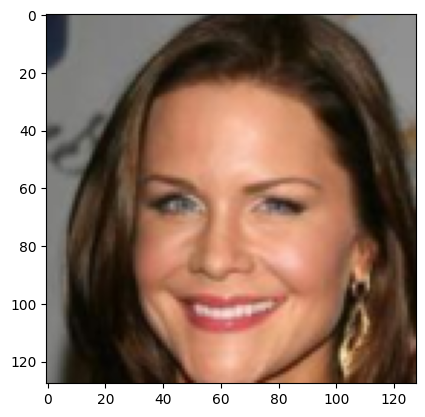

In [13]:
import sys
sys.path.append('../')
from helper_data import UnNormalize

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    
plt.imshow(np.transpose(unnormalizer(features[3]), (1, 2, 0)))

In [14]:
model.eval()
logits, probas = model(features.to(device)[3, None])
print('Probability Smile %.2f%%' % (probas[0][1]*100))

Probability Smile 99.89%


In [15]:
%watermark -iv

torch      : 2.6.0+cu126
pandas     : 2.2.3
sys        : 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0]
numpy      : 1.26.4
PIL        : 11.1.0
torchvision: 0.21.0+cu126
matplotlib : 3.10.1

